## DQN Tutorial

In [14]:
%matplotlib inline

In [15]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [16]:
from collections import namedtuple

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [18]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Bit flipping environment

In [19]:
class BitFlipEnv():
    
    def __init__(self, n = 8):
        self.n = n
        self.init_state = np.random.randint(2, size=n)
        self.target_state = np.random.randint(2, size=n)
        while np.array_equal(self.init_state, self.target_state):
            self.target_state = np.random.randint(2, size=n)
        self.curr_state = np.copy(self.init_state)
        
    def step(self, action):
        self.curr_state[action] = 1 - self.curr_state[action]
        if np.array_equal(self.curr_state, self.target_state):
            return np.copy(self.curr_state), 0
        else:
            return np.copy(self.curr_state), -1
        
    def reset(self):
        self.init_state = np.random.randint(2, size=self.n)
        self.target_state = np.random.randint(2, size=self.n)
        self.curr_state = np.copy(self.init_state)

In [24]:
env = BitFlipEnv(n=10)

In [25]:
print('Initial state:', env.init_state)
print('Target state:', env.target_state)
curr_state, reward = env.step(9)
print('State, reward after taking action 9:', curr_state, reward)
env.reset()

Initial state: [0 0 0 1 0 1 1 1 0 1]
Target state: [0 0 1 0 0 0 1 0 1 0]
State, reward after taking action 9: [0 0 0 1 0 1 1 1 0 0] -1


## Replay Memory

In [52]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward', 'goal'))

class ReplayMemory(object):
    
    def __init__(self, capacity = 1e5):
        self.capacity = capacity
        self.memory = []
    
    def push(self, *args):
        """Saves a transition which should contain:
        - current state
        - action taken
        - next state
        - reward obtained
        - goal state"""
        self.memory.append(Transition(*args))
        if len(self.memory) > self.capacity:
#             print('!!!!!exceeded!')
            del self.memory[0]

    def sample(self, batch_size):
        """
        Returns batch_size number of samples from the replay memory
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [53]:
replay = ReplayMemory(2)
print(replay.capacity)
replay.push(curr_state, 9, curr_state, 0, curr_state)
print(len(replay))
print(replay.memory)
curr_state, reward = env.step(9)
replay.push(curr_state, 9, curr_state, 1, curr_state)
print(len(replay))
print(replay.memory)
curr_state, reward = env.step(1)
replay.push(curr_state, 1, curr_state, 2, curr_state)
print(len(replay))
print(replay.memory)

replay.sample(1)

2
1
[Transition(state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), action=9, next_state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), reward=0, goal=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1]))]
2
[Transition(state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), action=9, next_state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), reward=0, goal=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1])), Transition(state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), action=9, next_state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), reward=1, goal=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]))]
!!!!!exceeded!
2
[Transition(state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), action=9, next_state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), reward=1, goal=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])), Transition(state=array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0]), action=1, next_state=array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0]), reward=2, goal=array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0]))]


[Transition(state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), action=9, next_state=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]), reward=1, goal=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0]))]

## Q-Network in pytorch

In [24]:
class DQN(nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Feedforward network

In [25]:
NUM_BITS = 10
HIDDEN_SIZE = 256
OUTPUT = 1 

In [26]:
class FNN(nn.Module):
    
    def __init__(self):
        super(FNN, self).__init__()
        self.ln1 = nn.Linear(NUM_BITS*2, HIDDEN_SIZE)
        self.ln2 = nn.Linear(HIDDEN_SIZE, OUTPUT)
        
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x
    

## Input extraction

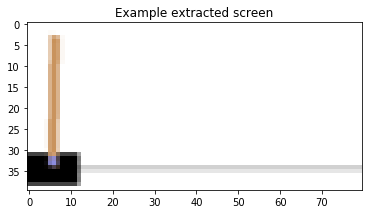

In [27]:
resize = T.Compose([T.ToPILImage(),
                   T.Resize(40, interpolation=Image.CUBIC), 
                   T.ToTensor()])

screen_width = 600

def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0) #MIDDLE OF CART

def get_screen():
    screen = env.render(mode='rgb_array').transpose(2, 0, 1) # to get into torch orde (C, H , W)?
    # stirp the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width) // 2:
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, 
                           cart_locaiton + view_width // 2)
        
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), 
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Hyper parameters

In [28]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
MODEL_PATH = 'policy_net.pt'
WEIGHTS_PATH = 'policy_net_weights.pt'

## Initialize Model

In [29]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

## Helper functions

In [30]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else: 
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [31]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
                                           batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state 
                                      if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
num_episodes = 1000
for i_episode in range(num_episodes):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

## save weights
torch.save(policy_net.state_dict(), WEIGHTS_PATH)
print('Weights saved')
torch.save(policy_net, MODEL_PATH)
print('Model saved')

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()
                

<Figure size 432x288 with 0 Axes>